In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from util import datasets, methods
from benchmark.masking.dataset_masking import generate_masked_geometry_dataset, MaskedGeometryDataset, dataset_masking_accuracy
from benchmark import train_model, test_model
import pickle as pkl
from os import path
import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
batch_size = 16
data_root = "../data"
dataset_loc = "geometry/basic"
model_loc = "models/basic_geometry_cnn.pkl"
load_model = True  # If False, model will be trained on dataset
normalize_attrs = True
aggregation_fn = "avg"

In [4]:
dataset = MaskedGeometryDataset(batch_size, path.join(data_root, dataset_loc))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 3, 1)
        self.conv2 = nn.Conv2d(20, 20, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(720, 128)
        self.fc2 = nn.Linear(128, 2)

    def get_logits(self, x):
        relu = nn.ReLU()
        x = self.conv1(x)
        x = relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 16)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = relu(x)
        x = self.dropout2(x)
        return self.fc2(x)

    def forward(self, x):
        if x.dtype != torch.float32:
            x = x.float()
        logits = self.get_logits(x)
        return F.softmax(logits, dim=1)

In [6]:
if load_model:
    with open(path.join(data_root, model_loc), "rb") as f:
        model = pkl.load(f)
    test_model(model, dataset)
else:
    model = Net()
    train_model(model, dataset, lr=1.0, gamma=0.7, epochs=2)
    with open(path.join(data_root, model_loc), "wb") as f:
        pkl.dump(model, f)
model.eval()


Test set: Average loss: 0.7989, Accuracy: 511/1000 (51%)
Positive samples: 500/1000 (50%)



Net(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [7]:
kwargs = {
    "normalize": normalize_attrs,
    "aggregation_fn": aggregation_fn
}

attribution_methods = {
    #"GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": methods.Gradient(model, **kwargs),
    "InputXGradient": methods.InputXGradient(model, **kwargs),
    "IntegratedGradients": methods.IntegratedGradients(model, **kwargs),
    "GuidedBackprop": methods.GuidedBackprop(model, **kwargs),
    "Deconvolution": methods.Deconvolution(model, **kwargs),
    "Random": methods.Random(**kwargs)
}

In [8]:
results = dataset_masking_accuracy(dataset, attribution_methods)

Batch 1/63...
Batch 2/63...
Batch 3/63...
Batch 4/63...
Batch 5/63...
Batch 6/63...
Batch 7/63...
Batch 8/63...
Batch 9/63...
Batch 10/63...
Batch 11/63...
Batch 12/63...
Batch 13/63...
Batch 14/63...
Batch 15/63...
Batch 16/63...
Batch 17/63...
Batch 18/63...
Batch 19/63...
Batch 20/63...
Batch 21/63...
Batch 22/63...
Batch 23/63...
Batch 24/63...
Batch 25/63...
Batch 26/63...
Batch 27/63...
Batch 28/63...
Batch 29/63...
Batch 30/63...
Batch 31/63...
Batch 32/63...
Batch 33/63...
Batch 34/63...
Batch 35/63...
Batch 36/63...
Batch 37/63...
Batch 38/63...
Batch 39/63...
Batch 40/63...
Batch 41/63...
Batch 42/63...
Batch 43/63...
Batch 44/63...
Batch 45/63...
Batch 46/63...
Batch 47/63...
Batch 48/63...
Batch 49/63...
Batch 50/63...
Batch 51/63...
Batch 52/63...
Batch 53/63...
Batch 54/63...
Batch 55/63...
Batch 56/63...
Batch 57/63...
Batch 58/63...
Batch 59/63...
Batch 60/63...
Batch 61/63...
Batch 62/63...
Batch 63/63...


/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


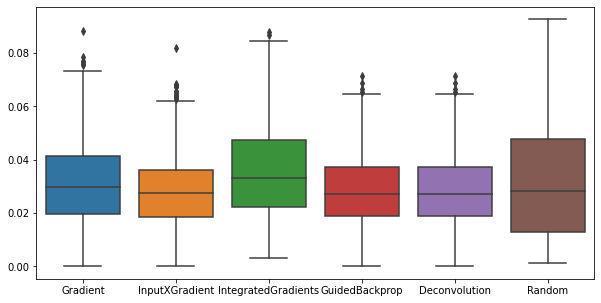

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame.from_dict(results))